# 9B_vocab_go_terms
12/01/2020

- a. Dot plot of subset of common normal tissue vocabularies ? 
- b.    GO terms of common normal tissue vocabulary connected genes
- c.    Dot plot of a subset of regulatory TF vocabularies across all 17 normal cell types
- d.    Dot plot of common cancer vocabularies
- e.     Common cancer connected vocab genes and/or GO Terms

edit 6/14/21
make a kc centric version fo nromal_vocab_config_wt_bar.pdf


6/16/21
also get vocab genesets for all the vocab words in all tissues

dot plots in R


7/9/2021 - get average number of footprints per crm

In [1]:
import pybedtools
import pandas as pd
import os,glob
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict,Counter
import scipy

In [2]:
%load_ext autoreload

%autoreload 2

# 0. Setup

In [3]:
save_dir = '../data/processed/fig7_vocab_go'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [4]:
# tfs 
tf_annon_df = pd.read_csv('../data/external/HOCOMOCOv11_annotation.csv',index_col=0)
tf_annon_df['id_trim'] = tf_annon_df['id'] + '.pwm.trim'
tf_name_to_id_dict = pd.Series(tf_annon_df.id_trim.values, index=tf_annon_df.tf.values).to_dict()
tf_id_to_name_dict = pd.Series(tf_annon_df.tf.values, index=tf_annon_df.id_trim.values).to_dict()

In [5]:
normal_tissues = ['Colon', 'GDSD6', 'GM12878', 'Melanocytes']
cancer_tissues = ['SCC','MM']
kc_tissues = ['GDSD6']
tissue_mapper = {
    'Colon':['Colon'], 'GDSD6':['GDSD6'], 'GM12878':['GM12878'], 'Melanocytes':['Melanocytes'],
    'SCC':['A431-CTRLi','CAL27-CTRLi','SCC13-CTRLi'], 'MM':['COLO_SCR_DMSO','WM_SCR_DMSO']
}

## vocab to gene assignments


In [20]:
%%time
# need this for making geneset
data_type='sum'#comb'
data_all = pd.read_csv('../data/processed/tissue_crms/all_count_'+data_type +'_overall.csv',index_col=0,header=0)
print(data_all.shape)
tissue_to_data_sel = {}
for tissue, tissue_set in tissue_mapper.items():
    tissue_to_data_sel[tissue] = data_all[data_all.tissue.isin(tissue_set)]
data_all[:5]

(793952, 534)
CPU times: user 35.8 s, sys: 9.84 s, total: 45.6 s
Wall time: 37.2 s


,tissue,exp,num_loop_counts,num_loops,num_atac_regions,AHR,ARID5B,ARNT,ARNTL,ATF1,...,NKX6-1,VAX1,ZIC1,HMX1,MAFA,MEOX1,E2F5,ESR2,KLF14,TBX15
A1BG,A431-CTRLi,3.740,13868.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1BG-AS1,A431-CTRLi,0.405,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1CF,A431-CTRLi,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A2M,A431-CTRLi,0.025,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A2M-AS1,A431-CTRLi,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
%%time
# need this for doing the pro-pro, pro-loop, loop-loop configurations
data_type='comb'
data_all_comb = pd.read_csv('../data/processed/tissue_crms/all_count_'+data_type +'_overall.csv',index_col=0,header=0)
print(data_all_comb.shape)
tissue_to_data_comb_sel = {}
for tissue, tissue_set in tissue_mapper.items():
    tissue_to_data_comb_sel[tissue] = data_all_comb[data_all_comb.tissue.isin(tissue_set)]
data_all_comb[:5]

(793952, 1063)
CPU times: user 1min 23s, sys: 19.1 s, total: 1min 42s
Wall time: 1min 28s


,tissue,exp,num_loop_counts,num_loops,num_atac_regions_pro,num_atac_regions_loop,AHR_pro,ARID5B_pro,ARNT_pro,ARNTL_pro,...,MAFA_loop,MEOX1_loop,E2F5_pro,E2F5_loop,ESR2_pro,KLF14_pro,TBX15_pro,ESR2_loop,KLF14_loop,TBX15_loop
A1BG,A431-CTRLi,3.740,13868.0,14.0,0.0,102.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1BG-AS1,A431-CTRLi,0.405,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1CF,A431-CTRLi,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A2M,A431-CTRLi,0.025,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A2M-AS1,A431-CTRLi,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
data_all_comb.tissue.unique()

array(['A431-CTRLi', 'A431-p63i', 'Airway', 'Astrocytes', 'Bladder',
       'CAL27-CTRLi', 'CAL27-p63i', 'COLO_SCR_DMSO', 'COLO_SCR_PLX',
       'COLO_shMITF_DMSO', 'COLO_shMITF_PLX', 'Colon', 'D0-CTRLi',
       'D0-p63i', 'D3-CTRLi', 'D3-p63i', 'Esophageal', 'GDSD0', 'GDSD3',
       'GDSD6', 'GM12878', 'HMEC', 'Melanocytes', 'Ovarian', 'Pancreas',
       'Prostate', 'Renal', 'SCC13-CTRLi', 'SCC13-p63i', 'Thyroid',
       'Uterine', 'WM_SCR_DMSO'], dtype=object)

Between XXX and XXX motif footprints were found per cell type and an average of XXX of footprints were part of a given gene’s CRM. 

In [26]:
# number of unique tfs used
print((data_all[data_all.tissue.isin(normal_tissues)].iloc[:,5:]>=1).sum(axis=1).describe())

# number of unique tfs and orientations used
print((data_all_comb[data_all.tissue.isin(normal_tissues)].iloc[:,6:]>=1).sum(axis=1).describe())

count    99244.000000
mean         2.754867
std         15.841410
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        234.000000
dtype: float64
count    99244.000000
mean        14.700637
std         30.727371
min          0.000000
25%          0.000000
50%          0.000000
75%         13.000000
max        281.000000
dtype: float64


all
count    99244.000000
mean         5.562825
std         30.580870
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        200.000000
dtype: float64
exp
count    40957.000000
mean         8.966843
std         38.683550
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        200.000000
dtype: float64


/Users/mguo123/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


low
count    24253.000000
mean         5.436029
std         30.036665
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        200.000000
dtype: float64
no
count    34034.000000
mean         1.556737
std         15.917107
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        200.000000
dtype: float64


MannwhitneyuResult(statistic=729791153.5, pvalue=1.8769076037526813e-250)

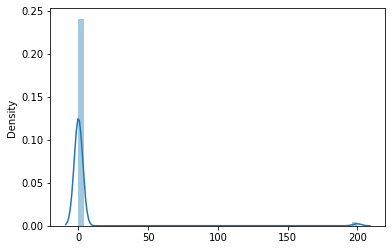

In [50]:
# number total tfs ued
# outliers excludinded
max_value = 100*2 # more than 2 standard devs about 
sum_counts = (data_all[data_all.tissue.isin(normal_tissues)].iloc[:,5:]).sum(axis=1)
sum_counts[sum_counts>max_value] = max_value
print('all')
print(sum_counts.describe())

sum_counts_exp = sum_counts[data_all[data_all.tissue.isin(normal_tissues)].exp>1]
sum_counts_exp[sum_counts_exp>max_value] = max_value
print('exp')
print(sum_counts_exp.describe())
sns.distplot(sum_counts)

sum_counts_nolowexp = sum_counts[(data_all[data_all.tissue.isin(normal_tissues)].exp<=1)&(data_all[data_all.tissue.isin(normal_tissues)].exp>1e-3)]
sum_counts_nolowexp[sum_counts_nolowexp>max_value] = max_value
print('low')
print(sum_counts_nolowexp.describe())

sum_counts_noexp = sum_counts[data_all[data_all.tissue.isin(normal_tissues)].exp<=1e-3]
sum_counts_noexp[sum_counts_noexp>max_value] = max_value
print('no')
print(sum_counts_noexp.describe())

# test by mann-whitney
from scipy.stats import mannwhitneyu, t
mannwhitneyu(sum_counts_exp, sum_counts_noexp, alternative='greater')


# sum_counts = data_all_comb[data_all_comb.tissue.isin(normal_tissues)].groupby('tissue').sum()
# sum_counts = sum_counts.drop(['exp','num_loop_counts','num_loops',
#                  'num_atac_regions_pro','num_atac_regions_loop'], axis=1)


In [10]:
sum_counts.sum(axis=1).describe()

count    4.000000e+00
mean     1.017670e+06
std      6.116839e+05
min      2.903910e+05
25%      8.050568e+05
50%      9.966505e+05
75%      1.209264e+06
max      1.786988e+06
dtype: float64

In [37]:
per_crm_counts = data_all_comb[data_all_comb.tissue.isin(normal_tissues)].drop(['exp','num_loop_counts','num_loops',
                 'num_atac_regions_pro','num_atac_regions_loop'], axis=1).sum(axis=1)

In [42]:
per_crm_counts[per_crm_counts>50] = 50
per_crm_counts.describe()

count    99244.000000
mean        11.657148
std         19.847348
min          0.000000
25%          0.000000
50%          0.000000
75%         17.000000
max         50.000000
dtype: float64

In [40]:
per_crm_counts[per_crm_counts!=0].describe()

count    30230.000000
mean       134.656963
std        186.027564
min          1.000000
25%         25.000000
50%         68.000000
75%        168.000000
max       2978.000000
dtype: float64

## vocab words


In [20]:
mpra_lib_df = pd.read_csv('../data/processed/fig4_modelling/vocab_sum_final/for_ld/vocab_instances20_seqs_sel.csv',index_col=0)

mpra_lib_df[:5]

,vocab_pair,tot_dist,btn_dist,chr,start,stop,start_pad,stop_pad,vocab1,vocab1_start,...,vocab2_stop,tissue,loop_type,vocab_tissue_count,name,check_rs,scr_pass_rs,seq_config,seq,name_config
0,BARX2::FOXF2,28,14,chr1,206848337,206848365,206848284,206848418,BARX2,206848337,...,206848365,Colon,pro_pro,1,BARX2::FOXF2+Colon+1,0,True,A_B_seq,CTCAGCTCTCCCACAAGATCTCTGGGGAAGCTGGAAGAGGGCCACT...,BARX2::FOXF2+Colon+1+A_B
1,BARX2::FOXF2,54,40,chr4,38859601,38859655,38859561,38859695,FOXF2,38859601,...,38859655,Colon,loop_loop,2,BARX2::FOXF2+Colon+2,0,True,A_B_seq,GTGGCTCTGAGGGAATTTCAAGTAACCGTGGACTAAAGTCTTAAGA...,BARX2::FOXF2+Colon+2+A_B
2,BARX2::FOXF2,46,32,chr6,74222776,74222822,74222732,74222866,FOXF2,74222776,...,74222822,Colon,loop_loop,3,BARX2::FOXF2+Colon+3,0,True,A_B_seq,GCCACTGCACTCCAGCCTGGTGACAGAGCGAGACTCTGTCTCAAGA...,BARX2::FOXF2+Colon+3+A_B
3,BARX2::FOXF2,16,2,chr3,49384674,49384690,49384615,49384749,FOXF2,49384674,...,49384690,Colon,pro_pro,4,BARX2::FOXF2+Colon+4,0,True,A_B_seq,AGTATTATGTGCTCATGGTCCCTACCCTCCAGGGTTCACAGTGTGG...,BARX2::FOXF2+Colon+4+A_B
4,BARX2::FOXF2,16,2,chr10,112247520,112247536,112247461,112247595,BARX2,112247520,...,112247536,Colon,pro_pro,5,BARX2::FOXF2+Colon+5,0,True,A_B_seq,ATGTGGCTGCGGGGCTTTAGGAGCTGACTCTTTGGTCACGGGGAGA...,BARX2::FOXF2+Colon+5+A_B


In [21]:
#  vocab words all only have one tissue assigned
mpra_lib_df[['vocab_pair','tissue']].drop_duplicates().vocab_pair.value_counts().unique()

array([1])

In [22]:
mpra_lib_df.vocab_pair.unique().shape

(239,)

In [23]:
print(mpra_lib_df.tissue.unique())


['Colon' 'GDSD6' 'GM12878' 'Melanocytes' 'SCC' 'MM']


# 1. normal tissues



In [24]:
normal_vocab_df = mpra_lib_df[mpra_lib_df.tissue.isin(normal_tissues)][['vocab_pair','tissue']].drop_duplicates().reset_index(drop=True).reset_index()
normal_vocab_df[['vocab1','vocab2']] = normal_vocab_df.vocab_pair.str.split('::',expand=True)
normal_vocab_df.to_csv(os.path.join(save_dir, 'normal_vocab_df.csv'))
normal_vocab_df[:5]

,index,vocab_pair,tissue,vocab1,vocab2
0,0,BARX2::FOXF2,Colon,BARX2,FOXF2
1,1,BARX2::FOXM1,Colon,BARX2,FOXM1
2,2,BARX2::THAP1,Colon,BARX2,THAP1
3,3,BATF::KLF15,Colon,BATF,KLF15
4,4,E2F7::THAP1,Colon,E2F7,THAP1


In [25]:
tissue_to_geneset = defaultdict(list)
for idx, row in normal_vocab_df.iterrows():
    data_all_sel = tissue_to_data_sel[row['tissue']]
    genes_sel = sorted(set(data_all_sel[(data_all_sel[row['vocab1']]>0) & (data_all_sel[row['vocab2']]>0)& (data_all_sel.exp>1)].index))
    print(row['vocab_pair'],row['tissue'],len(genes_sel))
    tissue_to_geneset[row['tissue']]+=genes_sel
    pd.Series(genes_sel).to_csv(os.path.join(save_dir, 'vocab_genesets', 
                                             row['tissue']+'_'+row['vocab1'] + '-' + row['vocab2']+'.txt'),
                               index=False, header=False)

NameError: name 'tissue_to_data_sel' is not defined

In [ ]:
for tissue, geneset in tissue_to_geneset.items():
    geneset = sorted(set(geneset))
    print(tissue, len(geneset))
    pd.Series(geneset).to_csv(os.path.join(save_dir,tissue+'_geneset.txt'),index=False, header=False)

## Normal cells vocab configurations

- pro_pro: # genes where  vocab1 and vocab2 are both present in pro
- pro_loop: # genes where  vocab1 and vocab2 are present in pro XOR loop but not both
- loop_loop: # genes where  vocab1 and vocab2 are both present in loop but are not in either of the other configurations

In [ ]:
data_all_comb[:5]

In [ ]:
normal_vocab_config_df = pd.DataFrame()
normal_vocab_config_df['tissue'] = ''
normal_vocab_config_df['vocab_pair']= ''
normal_vocab_config_df['genes_pro_pro']= ''
normal_vocab_config_df['genes_loop_loop']= ''
normal_vocab_config_df['genes_pro_loop']= ''
normal_vocab_config_df['genes_all_config']= ''
normal_vocab_config_df['weighting_factor'] = 1.0

In [ ]:
# tot_pro_footprints = data_all_comb[[x for x in data_all_comb.columns if '_pro' in x][1:]].sum().sum()
# tot_loop_footprints = data_all_comb[[x for x in data_all_comb.columns if '_loop' in x][3:]].sum().sum()
# print(tot_pro_footprints, tot_loop_footprints, tot_loop_footprints/tot_pro_footprints)

In [ ]:
%%time
for idx, row in normal_vocab_df.iterrows():
    data_all_sel = tissue_to_data_comb_sel[row['tissue']]
    data_all_sel = data_all_sel[data_all_sel.exp>1]# expression filter
    

    vocab1_pro_col = row['vocab1'] + '_pro'
    vocab1_loop_col = row['vocab1'] + '_loop'
    vocab2_pro_col = row['vocab2'] + '_pro'
    vocab2_loop_col = row['vocab2'] + '_loop'

    weighting_factor = data_all_sel[[vocab1_loop_col,vocab2_loop_col]].sum().sum()/data_all_sel[[vocab1_pro_col,vocab2_pro_col]].sum().sum()

    genes_pro_pro = set(data_all_sel[(data_all_sel[vocab1_pro_col]>0)&(data_all_sel[vocab2_pro_col]>0)].index)
    genes_loop_loop = set(data_all_sel[(data_all_sel[vocab1_loop_col]>0)&(data_all_sel[vocab2_loop_col]>0)].index)
    genes_loop_loop = genes_loop_loop - genes_pro_pro
    
    genes_pro_loop = set(data_all_sel[(data_all_sel[vocab1_pro_col]>0)&(data_all_sel[vocab2_pro_col]==0)&(data_all_sel[vocab1_loop_col]<=0)&(data_all_sel[vocab2_loop_col]>0)].index)
    genes_loop_pro = set(data_all_sel[(data_all_sel[vocab1_pro_col]==0)&(data_all_sel[vocab2_pro_col]>0)&(data_all_sel[vocab1_loop_col]>0)&(data_all_sel[vocab2_loop_col]<=0)].index)
    genes_pro_loop = genes_pro_loop.union(genes_loop_pro)
                                      
    genes_all_config = genes_pro_pro.union(genes_loop_loop).union(genes_pro_loop)
                                      
    normal_vocab_config_df.at[idx,'tissue'] = row['tissue']
    normal_vocab_config_df.at[idx,'vocab_pair']= row['vocab_pair']
    normal_vocab_config_df.at[idx,'weighting_factor'] = weighting_factor
    normal_vocab_config_df.at[idx,'genes_pro_pro']= genes_pro_pro
    normal_vocab_config_df.at[idx,'genes_loop_loop']= genes_loop_loop
    normal_vocab_config_df.at[idx,'genes_pro_loop']= genes_pro_loop
    normal_vocab_config_df.at[idx,'genes_all_config']= genes_all_config

    #     print(row['vocab_pair'],row['tissue'],len(genes_sel))
normal_vocab_config_df['num_genes_pro_pro'] = normal_vocab_config_df['genes_pro_pro'].map(len)
normal_vocab_config_df['num_genes_loop_loop']   = normal_vocab_config_df['genes_loop_loop'].map(len) 
normal_vocab_config_df['num_genes_pro_loop'] = normal_vocab_config_df['genes_pro_loop'].map(len)
normal_vocab_config_df['num_genes_all_config'] = normal_vocab_config_df['genes_all_config'].map(len)
                                     
normal_vocab_config_df['frac_genes_pro_pro'] = normal_vocab_config_df['num_genes_pro_pro']/normal_vocab_config_df['num_genes_all_config']
normal_vocab_config_df['frac_genes_loop_loop'] = normal_vocab_config_df['num_genes_loop_loop']/normal_vocab_config_df['num_genes_all_config']
normal_vocab_config_df['frac_genes_pro_loop'] = normal_vocab_config_df['num_genes_pro_loop']/normal_vocab_config_df['num_genes_all_config']
 
normal_vocab_config_df['frac_genes_pro_pro_wt'] = normal_vocab_config_df['num_genes_pro_pro']*2*normal_vocab_config_df['weighting_factor']
normal_vocab_config_df['frac_genes_loop_loop_wt'] = normal_vocab_config_df['num_genes_loop_loop']
normal_vocab_config_df['frac_genes_pro_loop_wt'] = normal_vocab_config_df['num_genes_pro_loop']*normal_vocab_config_df['weighting_factor']
normal_vocab_config_df['num_genes_all_config_wt'] = normal_vocab_config_df['frac_genes_pro_pro_wt'] + normal_vocab_config_df['frac_genes_loop_loop_wt'] + normal_vocab_config_df['frac_genes_pro_loop_wt']
normal_vocab_config_df['frac_genes_pro_pro_wt'] = normal_vocab_config_df['frac_genes_pro_pro_wt']/normal_vocab_config_df['num_genes_all_config_wt']
normal_vocab_config_df['frac_genes_loop_loop_wt'] = normal_vocab_config_df['frac_genes_loop_loop_wt']/normal_vocab_config_df['num_genes_all_config_wt']
normal_vocab_config_df['frac_genes_pro_loop_wt'] = normal_vocab_config_df['frac_genes_pro_loop_wt']/normal_vocab_config_df['num_genes_all_config_wt']
 
                             
                                      

In [ ]:
normal_vocab_config_df.to_csv(os.path.join(save_dir, 'normal_vocab_config_df.csv'))

In [ ]:
normal_vocab_config_frac = normal_vocab_config_df.set_index('vocab_pair')[['frac_genes_pro_pro','frac_genes_loop_loop','frac_genes_pro_loop']].sort_values('frac_genes_pro_pro')

ax = normal_vocab_config_frac.plot(kind='bar', stacked=True,figsize = (40,15),fontsize=11)
                                                                                                    
ax.figure.savefig(os.path.join(save_dir, 'normal_vocab_config_unwt_bar.pdf'))


In [ ]:
normal_vocab_config_wt = normal_vocab_config_df.set_index('vocab_pair')[['frac_genes_pro_pro_wt','frac_genes_loop_loop_wt','frac_genes_pro_loop_wt']].sort_values('frac_genes_pro_pro_wt')

ax = normal_vocab_config_wt.plot(kind='bar', stacked=True,figsize = (40,15),fontsize=11)
                                                                                                    
ax.figure.savefig(os.path.join(save_dir, 'normal_vocab_config_wt_bar.pdf'))


In [ ]:
normal_vocab_config_wt

In [ ]:
# fig,ax= plt.subplots(figsize = (20,7))
# ax.set_xlabel('xlabel', fontsize=6)


# ax.figure.savefig(os.path.join(save_dir, TISSUE+'_pro_count_norm_bar.pdf'))


## KCD6 cells vocab configurations

- pro_pro: # genes where  vocab1 and vocab2 are both present in pro
- pro_loop: # genes where  vocab1 and vocab2 are present in pro XOR loop but not both
- loop_loop: # genes where  vocab1 and vocab2 are both present in loop but are not in either of the other configurations

In [10]:
data_all_comb[:5]

,tissue,exp,num_loop_counts,num_loops,num_atac_regions_pro,num_atac_regions_loop,AHR_pro,ARID5B_pro,ARNT_pro,ARNTL_pro,...,MAFA_loop,MEOX1_loop,E2F5_pro,E2F5_loop,ESR2_pro,KLF14_pro,TBX15_pro,ESR2_loop,KLF14_loop,TBX15_loop
A1BG,A431-CTRLi,3.740,13868.0,14.0,0.0,102.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1BG-AS1,A431-CTRLi,0.405,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1CF,A431-CTRLi,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A2M,A431-CTRLi,0.025,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A2M-AS1,A431-CTRLi,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
kcd6_vocab_config_df = pd.DataFrame()
kcd6_vocab_config_df['tissue'] = ''
kcd6_vocab_config_df['vocab_pair']= ''
kcd6_vocab_config_df['genes_pro_pro']= ''
kcd6_vocab_config_df['genes_loop_loop']= ''
kcd6_vocab_config_df['genes_pro_loop']= ''
kcd6_vocab_config_df['genes_all_config']= ''
kcd6_vocab_config_df['weighting_factor'] = 1.0

In [20]:
kc_vocab_df = normal_vocab_df[normal_vocab_df.tissue=='GDSD6']
kc_vocab_df.shape

(49, 5)

In [21]:
`dd

SyntaxError: invalid syntax (<ipython-input-21-0befc9c6545b>, line 1)

In [22]:
%%time
for idx, row in kc_vocab_df.iterrows():
    data_all_sel = tissue_to_data_comb_sel[row['tissue']]
    data_all_sel = data_all_sel[data_all_sel.exp>1]# expression filter
    

    vocab1_pro_col = row['vocab1'] + '_pro'
    vocab1_loop_col = row['vocab1'] + '_loop'
    vocab2_pro_col = row['vocab2'] + '_pro'
    vocab2_loop_col = row['vocab2'] + '_loop'

    weighting_factor = data_all_sel[[vocab1_loop_col,vocab2_loop_col]].sum().sum()/data_all_sel[[vocab1_pro_col,vocab2_pro_col]].sum().sum()

    genes_pro_pro = set(data_all_sel[(data_all_sel[vocab1_pro_col]>0)&(data_all_sel[vocab2_pro_col]>0)].index)
    genes_loop_loop = set(data_all_sel[(data_all_sel[vocab1_loop_col]>0)&(data_all_sel[vocab2_loop_col]>0)].index)
    genes_loop_loop = genes_loop_loop - genes_pro_pro
    
    genes_pro_loop = set(data_all_sel[(data_all_sel[vocab1_pro_col]>0)&(data_all_sel[vocab2_pro_col]==0)&(data_all_sel[vocab1_loop_col]<=0)&(data_all_sel[vocab2_loop_col]>0)].index)
    genes_loop_pro = set(data_all_sel[(data_all_sel[vocab1_pro_col]==0)&(data_all_sel[vocab2_pro_col]>0)&(data_all_sel[vocab1_loop_col]>0)&(data_all_sel[vocab2_loop_col]<=0)].index)
    genes_pro_loop = genes_pro_loop.union(genes_loop_pro)
                                      
    genes_all_config = genes_pro_pro.union(genes_loop_loop).union(genes_pro_loop)
                                      
    kcd6_vocab_config_df.at[idx,'tissue'] = row['tissue']
    kcd6_vocab_config_df.at[idx,'vocab_pair']= row['vocab_pair']
    kcd6_vocab_config_df.at[idx,'weighting_factor'] = weighting_factor
    kcd6_vocab_config_df.at[idx,'genes_pro_pro']= genes_pro_pro
    kcd6_vocab_config_df.at[idx,'genes_loop_loop']= genes_loop_loop
    kcd6_vocab_config_df.at[idx,'genes_pro_loop']= genes_pro_loop
    kcd6_vocab_config_df.at[idx,'genes_all_config']= genes_all_config

    #     print(row['vocab_pair'],row['tissue'],len(genes_sel))
kcd6_vocab_config_df['num_genes_pro_pro'] = kcd6_vocab_config_df['genes_pro_pro'].map(len)
kcd6_vocab_config_df['num_genes_loop_loop']   = kcd6_vocab_config_df['genes_loop_loop'].map(len) 
kcd6_vocab_config_df['num_genes_pro_loop'] = kcd6_vocab_config_df['genes_pro_loop'].map(len)
kcd6_vocab_config_df['num_genes_all_config'] = kcd6_vocab_config_df['genes_all_config'].map(len)
                             
kcd6_vocab_config_df['frac_genes_pro_pro'] = kcd6_vocab_config_df['num_genes_pro_pro']/kcd6_vocab_config_df['num_genes_all_config']
kcd6_vocab_config_df['frac_genes_loop_loop'] = kcd6_vocab_config_df['num_genes_loop_loop']/kcd6_vocab_config_df['num_genes_all_config']
kcd6_vocab_config_df['frac_genes_pro_loop'] = kcd6_vocab_config_df['num_genes_pro_loop']/kcd6_vocab_config_df['num_genes_all_config']
kcd6_vocab_config_df['frac_genes_pro_pro_wt'] = kcd6_vocab_config_df['num_genes_pro_pro']*2*kcd6_vocab_config_df['weighting_factor']
kcd6_vocab_config_df['frac_genes_loop_loop_wt'] = kcd6_vocab_config_df['num_genes_loop_loop']
kcd6_vocab_config_df['frac_genes_pro_loop_wt'] = kcd6_vocab_config_df['num_genes_pro_loop']*kcd6_vocab_config_df['weighting_factor']

kcd6_vocab_config_df['num_genes_all_config_wt'] = kcd6_vocab_config_df['frac_genes_pro_pro_wt'] + kcd6_vocab_config_df['frac_genes_loop_loop_wt'] + kcd6_vocab_config_df['frac_genes_pro_loop_wt']
kcd6_vocab_config_df['frac_genes_pro_pro_wt'] = kcd6_vocab_config_df['frac_genes_pro_pro_wt']/kcd6_vocab_config_df['num_genes_all_config_wt']
kcd6_vocab_config_df['frac_genes_loop_loop_wt'] = kcd6_vocab_config_df['frac_genes_loop_loop_wt']/kcd6_vocab_config_df['num_genes_all_config_wt']
kcd6_vocab_config_df['frac_genes_pro_loop_wt'] = kcd6_vocab_config_df['frac_genes_pro_loop_wt']/kcd6_vocab_config_df['num_genes_all_config_wt']
 
                             
                                      

CPU times: user 2.07 s, sys: 518 ms, total: 2.58 s
Wall time: 2.59 s


In [33]:
kcd6_vocab_config_df.to_csv(os.path.join(save_dir, 'kcd6_vocab_config_df.csv'))

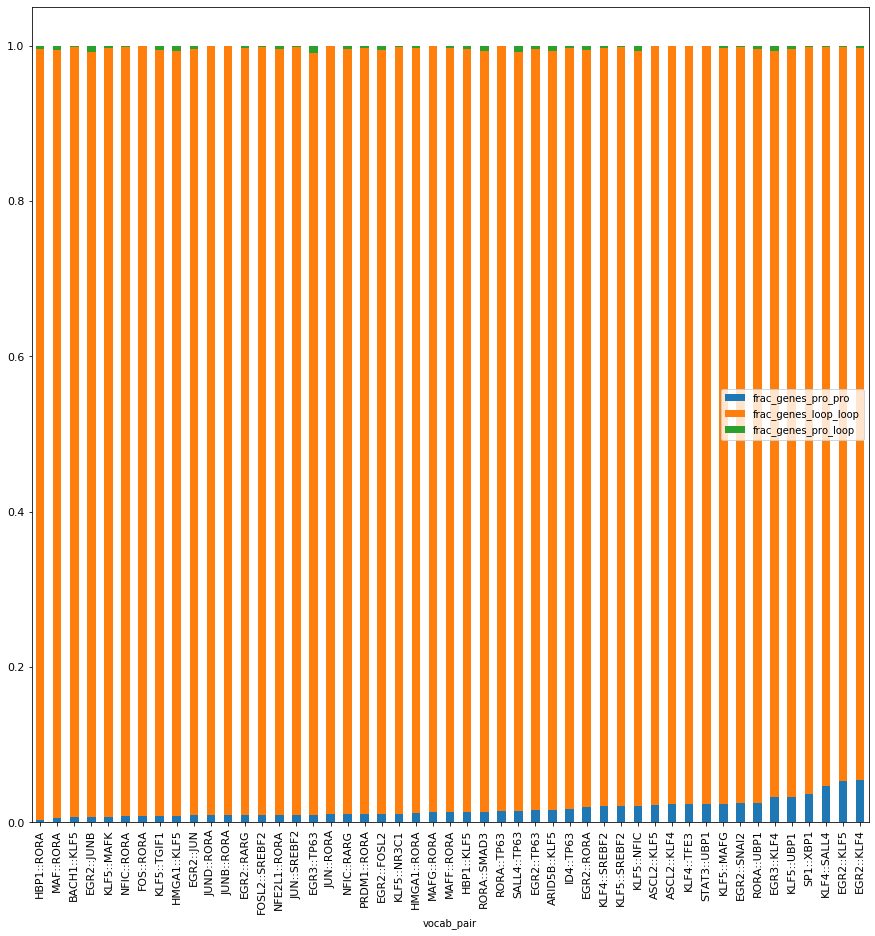

In [37]:
kcd6_vocab_config_frac = kcd6_vocab_config_df.set_index('vocab_pair')[['frac_genes_pro_pro','frac_genes_loop_loop','frac_genes_pro_loop']].sort_values('frac_genes_pro_pro')

ax = kcd6_vocab_config_frac.plot(kind='bar', stacked=True,figsize = (15,15),fontsize=11)
                                                                                                    
ax.figure.savefig(os.path.join(save_dir, 'kcd6_vocab_config_unwt_bar.pdf'))


In [39]:
save_dir

'../data/processed/fig7_vocab_go'

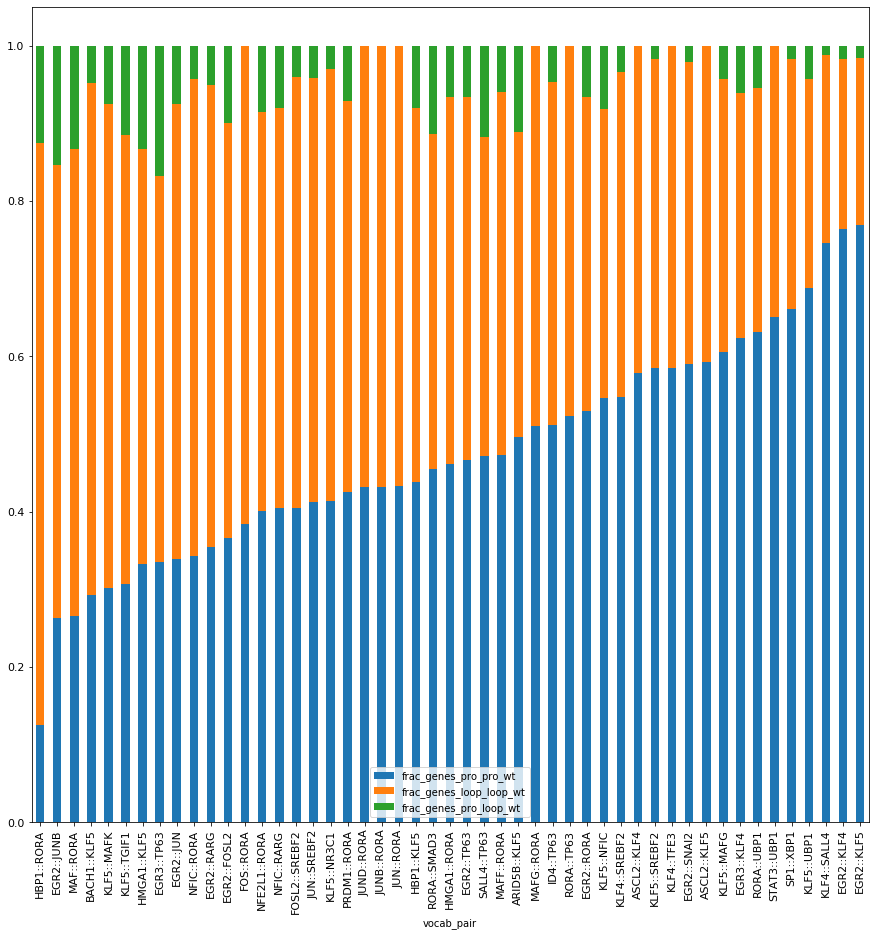

In [38]:
kcd6_vocab_config_wt = kcd6_vocab_config_df.set_index('vocab_pair')[['frac_genes_pro_pro_wt','frac_genes_loop_loop_wt','frac_genes_pro_loop_wt']].sort_values('frac_genes_pro_pro_wt')

ax = kcd6_vocab_config_wt.plot(kind='bar', stacked=True,figsize = (15,15),fontsize=11)
                                                                                                    
ax.figure.savefig(os.path.join(save_dir, 'kcd6_vocab_config_wt_bar.pdf'))


In [25]:
kcd6_vocab_config_df[:5]

,tissue,vocab_pair,genes_pro_pro,genes_loop_loop,genes_pro_loop,genes_all_config,weighting_factor,num_genes_pro_pro,num_genes_loop_loop,num_genes_pro_loop,num_genes_all_config,frac_genes_pro_pro,frac_genes_loop_loop,frac_genes_pro_loop,frac_genes_pro_pro_wt,frac_genes_loop_loop_wt,frac_genes_pro_loop_wt,num_genes_all_config_wt
42,GDSD6,ARID5B::KLF5,"{ANKZF1, GIT1, ACVR1B, GFOD1, COX7A1, S100A11,...","{DDX47, RPL18A, FLNA, ROM1, PMF1, TAX1BP3, NOP...","{MAN2B2, SLC4A1AP, KHDRBS1, SUPT7L, FNBP1L, ID...","{DDX47, RPL18A, FLNA, ROM1, PMF1, TAX1BP3, NOP...",38.191456,29,1751,13,1793,0.016174,0.976576,0.007250,0.496372,0.392373,0.111256,4462.593354
43,GDSD6,ASCL2::KLF4,"{GIT1, TUBB3, TNIP1, CCDC51, DPM2, PPIB, ACLY,...","{DDX47, RPL18A, PMF1, ZFAND2B, TAX1BP3, PGAM1,...",{},"{GIT1, DDX47, RPL18A, PMF1, ZFAND2B, TAX1BP3, ...",29.082143,11,467,0,478,0.023013,0.976987,0.000000,0.578066,0.421934,0.000000,1106.807143
44,GDSD6,ASCL2::KLF5,"{GIT1, TNIP1, CCDC51, DPM2, TNS4, PPIB, ACLY, ...","{CPEB2, DDX47, RPL18A, PMF1, ZFAND2B, TAX1BP3,...",{},"{GIT1, CPEB2, DDX47, RPL18A, PMF1, ZFAND2B, TA...",32.773381,11,496,0,507,0.021696,0.978304,0.000000,0.592445,0.407555,0.000000,1217.014388
45,GDSD6,BACH1::KLF5,"{ACLY, IDH1, PIKFYVE}","{NIF3L1, DDX47, PROSER2, ROM1, SOX15, LGALS3BP...",{MAN2B2},"{NIF3L1, DDX47, PROSER2, ROM1, SOX15, LGALS3BP...",33.669173,3,456,1,460,0.006522,0.991304,0.002174,0.292063,0.659260,0.048677,691.684211
46,GDSD6,EGR2::FOSL2,"{GSS, CCL27, EMD, ANXA2, RIN3, PHF23, WNT5B, C...","{DDX47, FLNA, SRP54, SOX15, PABPN1, SPRR2E, MY...","{SUPT7L, MAN2B2, SLC4A1AP, NDUFA6, PYGB, DVL1}","{DDX47, FLNA, SRP54, SOX15, PABPN1, SPRR2E, MY...",31.830986,11,1021,6,1038,0.010597,0.983622,0.005780,0.366205,0.533921,0.099874,1912.267606


In [ ]:
# fig,ax= plt.subplots(figsize = (20,7))
# ax.set_xlabel('xlabel', fontsize=6)


# ax.figure.savefig(os.path.join(save_dir, TISSUE+'_pro_count_norm_bar.pdf'))


# find the pro-loop genomic instances for specific cases

- 
MAF::RORA in KCD6?
{'PSMC3', 'TUBB3'

KCD6 pro_loop motif genomic instances for EGR2::FOSL2, EGR2::RARG, EGR2::RORA, and HMGA1::KLF5

In [36]:
import pybedtools 

def get_pro_loop_genomic_instance(vocab, vocab_config_df = kcd6_vocab_config_df):
    print('=======================')
    print( vocab)
    # get pro-loop genes with this vocab
    list_genes = list(vocab_config_df[vocab_config_df.vocab_pair==vocab].genes_pro_loop.values[0])
    print(list_genes)
    print(len(list_genes))
    
    # get anchors
    anc_prom = pybedtools.BedTool('../data/interim/annon/promoter_anchors/promoter_GDSD6_annon.bed').to_dataframe()
    anc_prom = anc_prom[anc_prom.name.isin(list_genes)]
    print('anc_prom', anc_prom.shape)
    
    # get anchors that loop to promoter anchors
    anc_prom_arr = anc_prom.thickEnd.unique()
    print('num promoter anchors', len(anc_prom_arr))
    
    # get loops
    loop_df = pd.read_csv('../data/interim/merged/loops/GDSD6.loops.csv',index_col=0)
    loop_df = loop_df[loop_df.source.isin(anc_prom_arr)|loop_df.target.isin(anc_prom_arr)]
    display(loop_df)
    all_anc = sorted(set(anc_prom.thickEnd.to_list() +loop_df.source.to_list() + loop_df.target.to_list() ))
    print('num all anchors', len(all_anc))#all_anc)
    
    # get footprinting anchor data
    anc_foot = pybedtools.BedTool('../data/interim/annon/anchor_footprinting/GDSD6_annon.bed').to_dataframe()
    anc_foot['tf'] = anc_foot.thickEnd.map(tf_id_to_name_dict)
    anc_foot = anc_foot[anc_foot.tf.isin(vocab.split('::'))]
    anc_foot = anc_foot[anc_foot.name.isin(all_anc)]
    print('number of footprinted anchors with vocab',anc_foot.shape)
    
    # get promoter footprinint data
    pro_anc_foot = pd.DataFrame()
    pro_anc_foot_df = pybedtools.BedTool('../data/interim/annon/promoter_footprinting/promoter_GDSD6_annon.bed').to_dataframe()
    pro_anc_foot_df['tf'] = pro_anc_foot_df.thickEnd.map(tf_id_to_name_dict)
    for gene in list_genes:
        pro_anc_foot1 = pro_anc_foot_df[(pro_anc_foot_df.name==gene)&(pro_anc_foot_df.tf.isin(vocab.split('::')))]# not perfect will catch later???
        pro_anc_foot = pd.concat([pro_anc_foot, pro_anc_foot1])

    genomic_instances = pd.concat([anc_foot,pro_anc_foot])
    print('*** genomic instances',genomic_instances.shape)
    display(genomic_instances)
    genomic_instances.to_csv(os.path.join(save_dir, '_'.join(vocab.split('::'))+'_genomic_instances.csv'))


In [38]:
save_dir

'../data/processed/fig7_vocab_go'

In [35]:
get_pro_loop_genomic_instance('MAF::RORA')

(((( MAF::RORA
['TUBB3', 'PSMC3']
2
anc_prom (3, 9)
num promoter anchors 2


,source,target,count
13270,chr11_47395000_47400000,chr11_47430000_47435000,19
13271,chr11_47400000_47405000,chr11_47430000_47435000,19
46752,chr16_89945000_89950000,chr16_89970000_89975000,13


num all anchors 5
number of footprinted anchors with vocab (3, 12)
*** genomic instances (5, 12)


,chrom,start,end,name,score,strand,thickStart,thickEnd,itemRgb,blockCount,blockSizes,tf
245086,chr11,47430000,47435000,chr11_47430000_47435000,chr11,47431397,47431406,MAF_HUMAN.H11MO.0.A.pwm.trim,11.190696,+,.,MAF
245088,chr11,47430000,47435000,chr11_47430000_47435000,chr11,47431400,47431406,MAF_HUMAN.H11MO.1.B.pwm.trim,11.159914,+,.,MAF
551162,chr16,89945000,89950000,chr16_89945000_89950000,chr16,89947615,89947621,MAF_HUMAN.H11MO.1.B.pwm.trim,11.159914,-,.,MAF
33641,chr16,89975800,89978300,TUBB3,chr16,89976871,89976880,RORA_HUMAN.H11MO.0.C.pwm.trim,10.669875,-,.,RORA
13820,chr11,47435993,47438493,PSMC3,chr11,47437909,47437918,RORA_HUMAN.H11MO.0.C.pwm.trim,11.555234,-,.,RORA


In [37]:
get_pro_loop_genomic_instance('EGR2::FOSL2')



EGR2::FOSL2
['SUPT7L', 'MAN2B2', 'SLC4A1AP', 'NDUFA6', 'PYGB', 'DVL1']
6
anc_prom (8, 9)
num promoter anchors 7


,source,target,count
66835,chr1_1250000_1255000,chr1_1275000_1280000,20
85339,chr20_24975000_24980000,chr20_25210000_25215000,16
85347,chr20_24980000_24985000,chr20_25220000_25225000,14
85351,chr20_25000000_25005000,chr20_25220000_25225000,11
85353,chr20_25175000_25180000,chr20_25220000_25225000,31
85355,chr20_25185000_25190000,chr20_25220000_25225000,20
95341,chr22_42335000_42340000,chr22_42470000_42475000,14
95342,chr22_42355000_42360000,chr22_42470000_42475000,13
95343,chr22_42360000_42365000,chr22_42470000_42475000,18
95344,chr22_42395000_42400000,chr22_42470000_42475000,15


num all anchors 20
number of footprinted anchors with vocab (7, 12)
*** genomic instances (14, 12)


,chrom,start,end,name,score,strand,thickStart,thickEnd,itemRgb,blockCount,blockSizes,tf
1314,chr1,1250000,1255000,chr1_1250000_1255000,chr1,1253766,1253775,FOSL2_HUMAN.H11MO.0.A.pwm.trim,15.191846,-,.,FOSL2
752856,chr2,27650000,27655000,chr2_27650000_27655000,chr2,27651403,27651413,EGR2_HUMAN.H11MO.1.A.pwm.trim,12.327744,-,.,EGR2
752881,chr2,27650000,27655000,chr2_27650000_27655000,chr2,27651999,27652009,EGR2_HUMAN.H11MO.1.A.pwm.trim,12.183181,+,.,EGR2
857187,chr20,25175000,25180000,chr20_25175000_25180000,chr20,25177379,25177389,EGR2_HUMAN.H11MO.1.A.pwm.trim,12.175070,-,.,EGR2
928806,chr22,42335000,42340000,chr22_42335000_42340000,chr22,42337092,42337101,FOSL2_HUMAN.H11MO.0.A.pwm.trim,13.586390,-,.,FOSL2
1021444,chr4,6560000,6565000,chr4_6560000_6565000,chr4,6564735,6564744,FOSL2_HUMAN.H11MO.0.A.pwm.trim,11.883532,-,.,FOSL2
1021482,chr4,6690000,6695000,chr4_6690000_6695000,chr4,6690862,6690871,FOSL2_HUMAN.H11MO.0.A.pwm.trim,15.723612,+,.,FOSL2
50821,chr2,27874676,27877176,SUPT7L,chr2,27875821,27875830,FOSL2_HUMAN.H11MO.0.A.pwm.trim,10.693595,-,.,FOSL2
63918,chr4,6564902,6567402,MAN2B2,chr4,6565550,6565560,EGR2_HUMAN.H11MO.1.A.pwm.trim,11.614258,-,.,EGR2
63942,chr4,6564902,6567402,MAN2B2,chr4,6565556,6565566,EGR2_HUMAN.H11MO.1.A.pwm.trim,11.194707,-,.,EGR2


In [39]:
get_pro_loop_genomic_instance('EGR2::RARG')


EGR2::RARG
['IFI30', 'RIN3']
2
anc_prom (2, 9)
num promoter anchors 2


,source,target,count
35551,chr14_92850000_92855000,chr14_92975000_92980000,14
35553,chr14_92930000_92935000,chr14_92975000_92980000,22
35555,chr14_92975000_92980000,chr14_93060000_93065000,16
60274,chr19_18220000_18225000,chr19_18275000_18280000,14


num all anchors 6
number of footprinted anchors with vocab (2, 12)
*** genomic instances (6, 12)


,chrom,start,end,name,score,strand,thickStart,thickEnd,itemRgb,blockCount,blockSizes,tf
439551,chr14,92975000,92980000,chr14_92975000_92980000,chr14,92978060,92978066,RARG_HUMAN.H11MO.1.B.pwm.trim,10.878001,-,.,RARG
697067,chr19,18275000,18280000,chr19_18275000_18280000,chr19,18279137,18279143,RARG_HUMAN.H11MO.1.B.pwm.trim,10.878001,+,.,RARG
44558,chr19,18271972,18274472,IFI30,chr19,18272644,18272662,EGR2_HUMAN.H11MO.0.A.pwm.trim,10.743191,-,.,EGR2
44568,chr19,18271972,18274472,IFI30,chr19,18272647,18272665,EGR2_HUMAN.H11MO.0.A.pwm.trim,12.269190,-,.,EGR2
44575,chr19,18271972,18274472,IFI30,chr19,18272649,18272659,EGR2_HUMAN.H11MO.1.A.pwm.trim,11.614258,-,.,EGR2
25595,chr14,92968118,92970618,RIN3,chr14,92970367,92970385,EGR2_HUMAN.H11MO.0.A.pwm.trim,11.012673,-,.,EGR2


In [40]:
get_pro_loop_genomic_instance('EGR2::RORA')



EGR2::RORA
['IFI30', 'GZF1', 'OSBPL2', 'NDUFA6']
4
anc_prom (4, 9)
num promoter anchors 4


,source,target,count
60274,chr19_18220000_18225000,chr19_18275000_18280000,14
85205,chr20_23030000_23035000,chr20_23325000_23330000,12
88994,chr20_60720000_60725000,chr20_60805000_60810000,15
88998,chr20_60760000_60765000,chr20_60805000_60810000,27
89000,chr20_60805000_60810000,chr20_60840000_60845000,24
95341,chr22_42335000_42340000,chr22_42470000_42475000,14
95342,chr22_42355000_42360000,chr22_42470000_42475000,13
95343,chr22_42360000_42365000,chr22_42470000_42475000,18
95344,chr22_42395000_42400000,chr22_42470000_42475000,15


num all anchors 13
number of footprinted anchors with vocab (4, 12)
*** genomic instances (14, 12)


,chrom,start,end,name,score,strand,thickStart,thickEnd,itemRgb,blockCount,blockSizes,tf
697071,chr19,18275000,18280000,chr19_18275000_18280000,chr19,18279144,18279153,RORA_HUMAN.H11MO.0.C.pwm.trim,11.043304,-,.,RORA
856079,chr20,23030000,23035000,chr20_23030000_23035000,chr20,23030940,23030949,RORA_HUMAN.H11MO.0.C.pwm.trim,11.181806,+,.,RORA
880976,chr20,60805000,60810000,chr20_60805000_60810000,chr20,60807633,60807642,RORA_HUMAN.H11MO.0.C.pwm.trim,10.777739,-,.,RORA
928796,chr22,42335000,42340000,chr22_42335000_42340000,chr22,42337076,42337085,RORA_HUMAN.H11MO.0.C.pwm.trim,11.555234,+,.,RORA
44558,chr19,18271972,18274472,IFI30,chr19,18272644,18272662,EGR2_HUMAN.H11MO.0.A.pwm.trim,10.743191,-,.,EGR2
44568,chr19,18271972,18274472,IFI30,chr19,18272647,18272665,EGR2_HUMAN.H11MO.0.A.pwm.trim,12.269190,-,.,EGR2
44575,chr19,18271972,18274472,IFI30,chr19,18272649,18272659,EGR2_HUMAN.H11MO.1.A.pwm.trim,11.614258,-,.,EGR2
54533,chr20,23330787,23333287,GZF1,chr20,23331750,23331768,EGR2_HUMAN.H11MO.0.A.pwm.trim,13.528981,-,.,EGR2
54552,chr20,23330787,23333287,GZF1,chr20,23332167,23332185,EGR2_HUMAN.H11MO.0.A.pwm.trim,14.748341,+,.,EGR2
54561,chr20,23330787,23333287,GZF1,chr20,23332173,23332183,EGR2_HUMAN.H11MO.1.A.pwm.trim,12.042722,+,.,EGR2


In [41]:
get_pro_loop_genomic_instance('HMGA1::KLF5')



HMGA1::KLF5
['GIT1', 'MAN2B2', 'FNBP1L', 'TDRP', 'IDH3B', 'PPP6R1', 'PAFAH1B3', 'NHSL1']
8
anc_prom (11, 9)
num promoter anchors 11


,source,target,count
47811,chr17_27910000_27915000,chr17_27950000_27955000,21
62062,chr19_42610000_42615000,chr19_42790000_42795000,11
62063,chr19_42610000_42615000,chr19_42800000_42805000,12
62093,chr19_42615000_42620000,chr19_42790000_42795000,1916
62094,chr19_42615000_42620000,chr19_42800000_42805000,2327
62132,chr19_42630000_42635000,chr19_42800000_42805000,12
62157,chr19_42695000_42700000,chr19_42790000_42795000,14
62158,chr19_42695000_42700000,chr19_42800000_42805000,15
62176,chr19_42720000_42725000,chr19_42800000_42805000,18
62180,chr19_42745000_42750000,chr19_42800000_42805000,19


num all anchors 37
number of footprinted anchors with vocab (13, 12)
*** genomic instances (24, 12)


,chrom,start,end,name,score,strand,thickStart,thickEnd,itemRgb,blockCount,blockSizes,tf
71210,chr1,94085000,94090000,chr1_94085000_94090000,chr1,94089666,94089677,KLF5_HUMAN.H11MO.0.A.pwm.trim,13.404482,-,.,KLF5
576291,chr17,27950000,27955000,chr17_27950000_27955000,chr17,27951105,27951110,HMGA1_HUMAN.H11MO.0.D.pwm.trim,7.983511,-,.,HMGA1
576341,chr17,27950000,27955000,chr17_27950000_27955000,chr17,27952516,27952521,HMGA1_HUMAN.H11MO.0.D.pwm.trim,7.983511,+,.,HMGA1
713278,chr19,42615000,42620000,chr19_42615000_42620000,chr19,42616171,42616176,HMGA1_HUMAN.H11MO.0.D.pwm.trim,7.983511,-,.,HMGA1
736169,chr19,55720000,55725000,chr19_55720000_55725000,chr19,55721699,55721704,HMGA1_HUMAN.H11MO.0.D.pwm.trim,7.983511,+,.,HMGA1
846297,chr20,2505000,2510000,chr20_2505000_2510000,chr20,2505437,2505442,HMGA1_HUMAN.H11MO.0.D.pwm.trim,7.983511,+,.,HMGA1
846308,chr20,2505000,2510000,chr20_2505000_2510000,chr20,2505443,2505448,HMGA1_HUMAN.H11MO.0.D.pwm.trim,7.983511,+,.,HMGA1
1021401,chr4,6390000,6395000,chr4_6390000_6395000,chr4,6393736,6393741,HMGA1_HUMAN.H11MO.0.D.pwm.trim,7.983511,-,.,HMGA1
1021524,chr4,6690000,6695000,chr4_6690000_6695000,chr4,6694909,6694914,HMGA1_HUMAN.H11MO.0.D.pwm.trim,7.983511,+,.,HMGA1
1208171,chr6,138975000,138980000,chr6_138975000_138980000,chr6,138976116,138976121,HMGA1_HUMAN.H11MO.0.D.pwm.trim,7.983511,+,.,HMGA1


note: make sure to eyeball all genomic instances to make sure if one vocab appears in promoter ends the other vocab word appears in anchor only regions

# Cancer

modify the vocabs

In [17]:
new_mpra_df = pd.read_csv('../data/processed/mpra/results_df_piv_match_count.csv')
new_mpra_df = new_mpra_df[new_mpra_df.tissue.isin(['MM','SCC'])][['vocab','tissue']].rename(columns={"vocab": "vocab_pair"}).drop_duplicates()
new_mpra_df

,vocab_pair,tissue
1,ARID5B::LEF1,MM
2,ARID5B::NFE2L1,MM
3,ARID5B::SOX10,MM
4,ARID5B::STAT1,MM
5,ARNT::SP1,SCC
...,...,...
230,STAT1::TBX15,MM
231,STAT1::UBP1,MM
235,TFAP2C::ZBTB14,SCC
236,TFAP2C::ZNF219,SCC


In [19]:
# original
# cancer_vocab_df = mpra_lib_df[mpra_lib_df.tissue.isin(cancer_tissues)][['vocab_pair','tissue']].drop_duplicates().reset_index(drop=True).reset_index()
cancer_vocab_df = new_mpra_df
cancer_vocab_df[['vocab1','vocab2']] = cancer_vocab_df.vocab_pair.str.split('::',expand=True)
cancer_vocab_df.to_csv(os.path.join(save_dir, 'cancer_vocab_df.csv'))
cancer_vocab_df[:5]

,vocab_pair,tissue,vocab1,vocab2
1,ARID5B::LEF1,MM,ARID5B,LEF1
2,ARID5B::NFE2L1,MM,ARID5B,NFE2L1
3,ARID5B::SOX10,MM,ARID5B,SOX10
4,ARID5B::STAT1,MM,ARID5B,STAT1
5,ARNT::SP1,SCC,ARNT,SP1


In [ ]:
vocab_words = set(cancer_vocab_df.vocab1).union(set(cancer_vocab_df.vocab2))

In [26]:
data_all_sel

,tissue,exp,num_loop_counts,num_loops,num_atac_regions_pro,num_atac_regions_loop,AHR_pro,ARID5B_pro,ARNT_pro,ARNTL_pro,...,MAFA_loop,MEOX1_loop,E2F5_pro,E2F5_loop,ESR2_pro,KLF14_pro,TBX15_pro,ESR2_loop,KLF14_loop,TBX15_loop
A1BG,COLO_SCR_DMSO,48.420,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1BG-AS1,COLO_SCR_DMSO,0.130,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1CF,COLO_SCR_DMSO,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A2M,COLO_SCR_DMSO,37.565,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A2M-AS1,COLO_SCR_DMSO,0.010,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZYG11A,WM_SCR_DMSO,0.025,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ZYG11B,WM_SCR_DMSO,4.120,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ZYX,WM_SCR_DMSO,18.270,3186.0,13.0,0.0,41.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ZZEF1,WM_SCR_DMSO,1.290,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
tissue_to_geneset_cancer = defaultdict(list)
for idx, row in cancer_vocab_df.iterrows():
    data_all_sel = tissue_to_data_sel[row['tissue']]
    genes_sel = sorted(set(data_all_sel[(data_all_sel[row['vocab1']]>0) & (data_all_sel[row['vocab2']]>0)& (data_all_sel.exp>1)].index))
    print(row['vocab_pair'],row['tissue'],len(genes_sel))
    tissue_to_geneset_cancer[row['tissue']]+=genes_sel
    pd.Series(genes_sel).to_csv(os.path.join(save_dir, 'vocab_genesets', 
                                             row['tissue']+'_'+row['vocab1'] + '-' + row['vocab2']+'.txt'),
                               index=False, header=False)

ARID5B::LEF1 MM 464
ARID5B::NFE2L1 MM 823
ARID5B::SOX10 MM 607
ARID5B::STAT1 MM 615
ARNT::SP1 SCC 828
E2F1::SP1 SCC 1163
E2F3::TP63 SCC 1014
E2F6::SP1 SCC 1385
EGR1::SP1 SCC 1438
EGR1::SP3 SCC 1432
EGR2::NFE2L1 MM 610
EGR2::SOX10 MM 453
EGR2::STAT1 MM 462
EGR4::NFE2L1 MM 503
EN2::NFE2L1 MM 599
EN2::STAT1 MM 459
ETS1::SP1 SCC 1326
HBP1::STAT1 MM 467
HMGA1::LEF1 MM 403
HMGA1::NFE2L1 MM 718
HMGA1::SOX10 MM 544
HMGA1::STAT1 MM 539
IRX3::TP63 SCC 774
KLF16::SP1 SCC 1532
KLF16::SP3 SCC 1525
KLF16::TFAP2C SCC 1220
KLF4::KLF5 SCC 1509
KLF4::SP1 SCC 1518
KLF4::SP3 SCC 1502
KLF4::TFAP2C SCC 1225
KLF5::SP3 SCC 1528
KLF5::TFAP2C SCC 1222
KLF5::ZNF219 SCC 1424
KLF6::SP1 SCC 1550
LEF1::NFAT5 MM 464
LEF1::PRRX1 MM 388
LEF1::SOX13 MM 476
LEF1::UBP1 MM 478
MAZ::SP1 SCC 1583
NFAT5::NFE2L1 MM 808
NFAT5::SOX10 MM 596
NFAT5::SP1 SCC 1575
NFAT5::STAT1 MM 615
NFATC4::NFE2L1 MM 808
NFATC4::SOX10 MM 596
NFATC4::STAT1 MM 615
NFE2L1::NR3C1 MM 522
NFE2L1::PRRX1 MM 702
NFE2L1::SOX13 MM 849
NFE2L1::SP4 MM 732
NFE2L

In [56]:
for tissue, geneset in tissue_to_geneset_cancer.items():
    geneset = sorted(set(geneset))
    print(tissue, len(geneset))
    pd.Series(geneset).to_csv(os.path.join(save_dir,tissue+'_geneset.txt'),index=False, header=False)

SCC 1670
MM 837


## Cancer cells vocab configurations

- pro_pro: # genes where  vocab1 and vocab2 are both present in pro
- pro_loop: # genes where  vocab1 and vocab2 are present in pro XOR loop but not both
- loop_loop: # genes where  vocab1 and vocab2 are both present in loop but are not in either of the other configurations

In [112]:
cancer_vocab_config_df = pd.DataFrame()
cancer_vocab_config_df['tissue'] = ''
cancer_vocab_config_df['vocab_pair']= ''
cancer_vocab_config_df['genes_pro_pro']= ''
cancer_vocab_config_df['genes_loop_loop']= ''
cancer_vocab_config_df['genes_pro_loop']= ''
cancer_vocab_config_df['genes_all_config']= ''
cancer_vocab_config_df['weighting_factor'] = 1.0

In [115]:
# %%time
for idx, row in cancer_vocab_df.iterrows():
    data_all_sel = tissue_to_data_comb_sel[row['tissue']]
    data_all_sel = data_all_sel[data_all_sel.exp>1]# expression filter
    

    vocab1_pro_col = row['vocab1'] + '_pro'
    vocab1_loop_col = row['vocab1'] + '_loop'
    vocab2_pro_col = row['vocab2'] + '_pro'
    vocab2_loop_col = row['vocab2'] + '_loop'

    weighting_factor = data_all_sel[[vocab1_loop_col,vocab2_loop_col]].sum().sum()/data_all_sel[[vocab1_pro_col,vocab2_pro_col]].sum().sum()

    genes_pro_pro = set(data_all_sel[(data_all_sel[vocab1_pro_col]>0)&(data_all_sel[vocab2_pro_col]>0)].index)
    genes_loop_loop = set(data_all_sel[(data_all_sel[vocab1_loop_col]>0)&(data_all_sel[vocab2_loop_col]>0)].index)
    genes_loop_loop = genes_loop_loop - genes_pro_pro
    
    genes_pro_loop = set(data_all_sel[(data_all_sel[vocab1_pro_col]>0)&(data_all_sel[vocab2_pro_col]==0)&(data_all_sel[vocab1_loop_col]<=0)&(data_all_sel[vocab2_loop_col]>0)].index)
    genes_loop_pro = set(data_all_sel[(data_all_sel[vocab1_pro_col]==0)&(data_all_sel[vocab2_pro_col]>0)&(data_all_sel[vocab1_loop_col]>0)&(data_all_sel[vocab2_loop_col]<=0)].index)
    genes_pro_loop = genes_pro_loop.union(genes_loop_pro)
                                      
    genes_all_config = genes_pro_pro.union(genes_loop_loop).union(genes_pro_loop)
                                      
    cancer_vocab_config_df.at[idx,'tissue'] = row['tissue']
    cancer_vocab_config_df.at[idx,'vocab_pair']= row['vocab_pair']
    cancer_vocab_config_df.at[idx,'weighting_factor'] = weighting_factor
    cancer_vocab_config_df.at[idx,'genes_pro_pro']= genes_pro_pro
    cancer_vocab_config_df.at[idx,'genes_loop_loop']= genes_loop_loop
    cancer_vocab_config_df.at[idx,'genes_pro_loop']= genes_pro_loop
    cancer_vocab_config_df.at[idx,'genes_all_config']= genes_all_config

    #     print(row['vocab_pair'],row['tissue'],len(genes_sel))
cancer_vocab_config_df['num_genes_pro_pro'] = cancer_vocab_config_df['genes_pro_pro'].map(len)
cancer_vocab_config_df['num_genes_loop_loop']   = cancer_vocab_config_df['genes_loop_loop'].map(len) 
cancer_vocab_config_df['num_genes_pro_loop'] = cancer_vocab_config_df['genes_pro_loop'].map(len)
cancer_vocab_config_df['num_genes_all_config'] = cancer_vocab_config_df['genes_all_config'].map(len)

cancer_vocab_config_df['frac_genes_pro_pro'] = cancer_vocab_config_df['num_genes_pro_pro']/cancer_vocab_config_df['num_genes_all_config']
cancer_vocab_config_df['frac_genes_loop_loop'] = cancer_vocab_config_df['num_genes_loop_loop']/cancer_vocab_config_df['num_genes_all_config']
cancer_vocab_config_df['frac_genes_pro_loop'] = cancer_vocab_config_df['num_genes_pro_loop']/cancer_vocab_config_df['num_genes_all_config']

cancer_vocab_config_df['frac_genes_pro_pro_wt'] = cancer_vocab_config_df['num_genes_pro_pro']*2*cancer_vocab_config_df['weighting_factor']
cancer_vocab_config_df['frac_genes_loop_loop_wt'] = cancer_vocab_config_df['num_genes_loop_loop']
cancer_vocab_config_df['frac_genes_pro_loop_wt'] = cancer_vocab_config_df['num_genes_pro_loop']*cancer_vocab_config_df['weighting_factor']
cancer_vocab_config_df['num_genes_all_config_wt'] = cancer_vocab_config_df['frac_genes_pro_pro_wt'] + cancer_vocab_config_df['frac_genes_loop_loop_wt'] + cancer_vocab_config_df['frac_genes_pro_loop_wt']
cancer_vocab_config_df['frac_genes_pro_pro_wt'] = cancer_vocab_config_df['frac_genes_pro_pro_wt']/cancer_vocab_config_df['num_genes_all_config_wt']
cancer_vocab_config_df['frac_genes_loop_loop_wt'] = cancer_vocab_config_df['frac_genes_loop_loop_wt']/cancer_vocab_config_df['num_genes_all_config_wt']
cancer_vocab_config_df['frac_genes_pro_loop_wt'] = cancer_vocab_config_df['frac_genes_pro_loop_wt']/cancer_vocab_config_df['num_genes_all_config_wt']
 
                             
                                      

/Users/mguo123/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


In [107]:
cancer_vocab_config_df.to_csv(os.path.join(save_dir, 'cancer_vocab_config_df.csv'))

In [124]:
cancer_vocab_config_df_filt = cancer_vocab_config_df[cancer_vocab_config_df.num_genes_all_config>0]

In [123]:
data_all_sel['SP1_pro'].sum()

1092.0

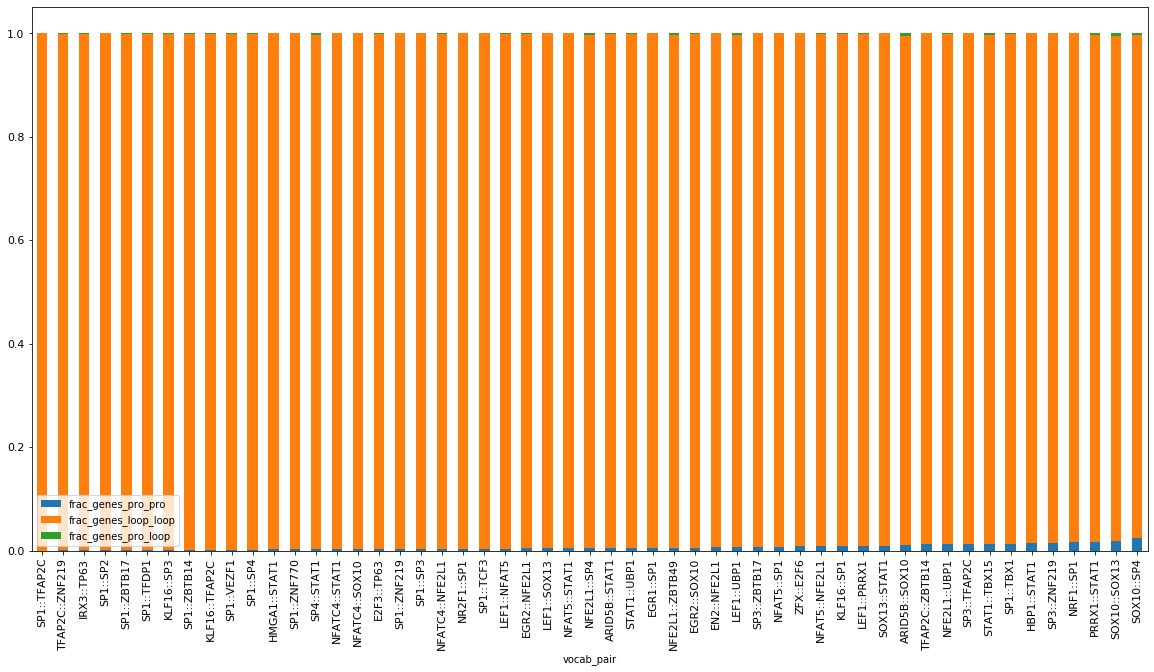

In [125]:
cancer_vocab_config_frac = cancer_vocab_config_df_filt.set_index('vocab_pair')[['frac_genes_pro_pro','frac_genes_loop_loop','frac_genes_pro_loop']].sort_values('frac_genes_pro_pro')

ax = cancer_vocab_config_frac.plot(kind='bar', stacked=True,figsize = (20,10),fontsize=11)
                                                                                                    
ax.figure.savefig(os.path.join(save_dir, 'cancer_vocab_config_unwt_bar.pdf'))


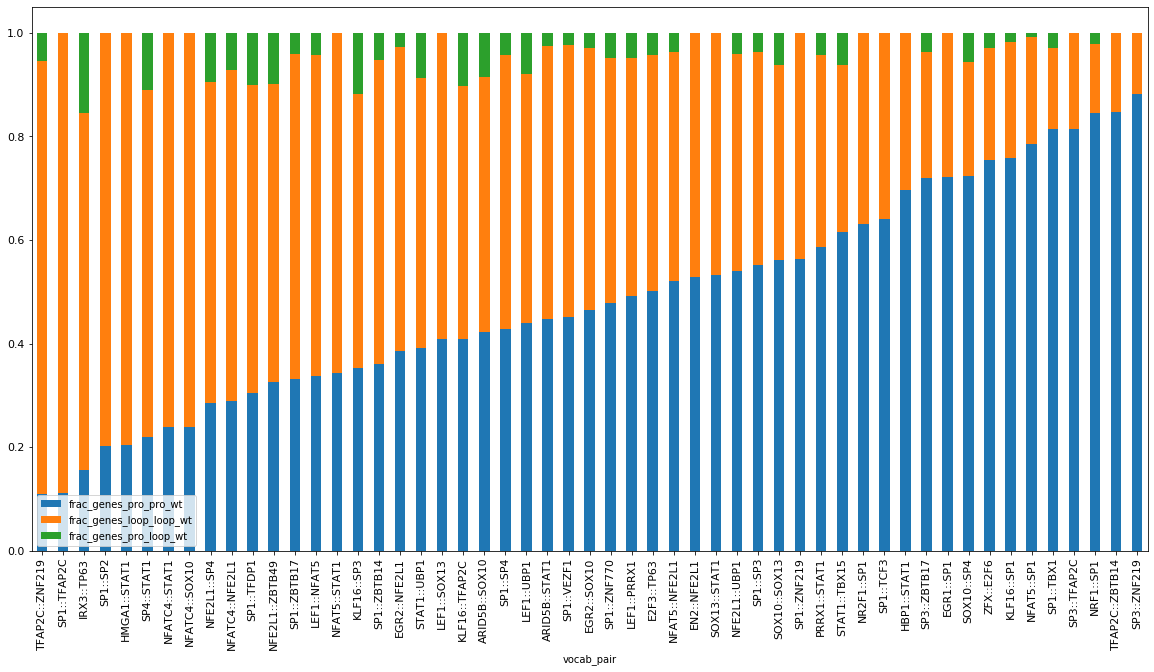

In [130]:
cancer_vocab_config_wt = cancer_vocab_config_df_filt.set_index('vocab_pair')[['frac_genes_pro_pro_wt','frac_genes_loop_loop_wt','frac_genes_pro_loop_wt']].sort_values('frac_genes_pro_pro_wt')

ax = cancer_vocab_config_wt.plot(kind='bar', stacked=True,figsize = (20,10),fontsize=11)
                                                                                                    
ax.figure.savefig(os.path.join(save_dir, 'cancer_vocab_config_wt_bar.pdf'))


# also get vocab genesets for all the vocab words in all tissues


In [29]:
save_dir_all_tissue = os.path.join(save_dir, 'vocab_geneset_all_tissue')
if not os.path.exists(save_dir_all_tissue):
    os.makedirs(save_dir_all_tissue)
save_dir_all_tissue

'../data/processed/fig7_vocab_go/vocab_geneset_all_tissue'

In [22]:
new_mpra_df = pd.read_csv('../data/processed/mpra/results_df_piv_match_count.csv',index_col=0)
# new_mpra_df = new_mpra_df[new_mpra_df.tissue.isin(['MM','SCC'])][['vocab','tissue']].rename(columns={"vocab": "vocab_pair"}).drop_duplicates()
new_mpra_df

,vocab,tissue,mpra_tissue,class,instance,count,consensus_class,tf1,tf2
0,ARID5B::KLF5,GDSD6,KCD6,other|other|other|other|LEADING_B|other|other|...,1|10|2|3|4|5|6|7|8|9,10,OR,ARID5B,KLF5
1,ARID5B::LEF1,MM,COLO,other|LEADING_B|other|OR|OR|AND|other|other|AN...,1|10|2|3|4|5|6|7|8|9,10,OR,ARID5B,LEF1
2,ARID5B::NFE2L1,MM,COLO,other|other|other|other|other|other|other|othe...,1|10|2|3|4|5|6|7|8|9,10,other,ARID5B,NFE2L1
3,ARID5B::SOX10,MM,COLO,other|other|LEADING_A|AND|other|other|other|OR...,1|10|2|3|4|5|6|7|8|9,10,OR,ARID5B,SOX10
4,ARID5B::STAT1,MM,COLO,other|other|other|other|other|other|other|othe...,1|10|2|3|4|5|6|7|8|9,10,other,ARID5B,STAT1
...,...,...,...,...,...,...,...,...,...
234,TFAP2B::ZNF589,Melanocytes,MC,other|other|other|other|other|other|OR|other|o...,1|10|2|3|4|5|6|7|8|9,10,other,TFAP2B,ZNF589
235,TFAP2C::ZBTB14,SCC,A431,other|other|other|other|other|other|LEADING_B|...,1|10|2|3|4|5|6|7|8|9,10,other,TFAP2C,ZBTB14
236,TFAP2C::ZNF219,SCC,A431,other|other|other|AND|OR|OR|OR|OR,1|10|2|5|6|7|8|9,8,OR,TFAP2C,ZNF219
237,THAP1::THRB,Colon,Colon,other|other|other|OR|AND|other|LEADING_A|other...,1|10|2|3|4|5|6|7|8|9,10,OR,THAP1,THRB


In [33]:
for idx, row in new_mpra_df.iterrows():
    for mpra_tissue in tissue_to_data_sel.keys():
        data_all_sel = tissue_to_data_sel[mpra_tissue]
        genes_sel = sorted(set(data_all_sel[(data_all_sel[row['tf1']]>0) & (data_all_sel[row['tf2']]>0)& (data_all_sel.exp>1)].index))
        print(row['vocab'],row['tissue'],mpra_tissue, len(genes_sel))
        if len(genes_sel)>0:
            save_file = os.path.join(save_dir_all_tissue, 
                                                     row['tissue']+'_'+row['tf1'] + '-' + row['tf2']+'_'+mpra_tissue+'.txt')
            print(save_file)
            pd.Series(genes_sel).to_csv(save_file,
                                       index=False, header=False)

ARID5B::KLF5 GDSD6 Colon 0
ARID5B::KLF5 GDSD6 GDSD6 409
../data/processed/fig7_vocab_go/vocab_geneset_all_tissue/GDSD6_ARID5B-KLF5_GDSD6.txt
ARID5B::KLF5 GDSD6 GM12878 0
ARID5B::KLF5 GDSD6 Melanocytes 64
../data/processed/fig7_vocab_go/vocab_geneset_all_tissue/GDSD6_ARID5B-KLF5_Melanocytes.txt
ARID5B::KLF5 GDSD6 SCC 1539
../data/processed/fig7_vocab_go/vocab_geneset_all_tissue/GDSD6_ARID5B-KLF5_SCC.txt
ARID5B::KLF5 GDSD6 MM 400
../data/processed/fig7_vocab_go/vocab_geneset_all_tissue/GDSD6_ARID5B-KLF5_MM.txt
ARID5B::LEF1 MM Colon 0
ARID5B::LEF1 MM GDSD6 0
ARID5B::LEF1 MM GM12878 121
../data/processed/fig7_vocab_go/vocab_geneset_all_tissue/MM_ARID5B-LEF1_GM12878.txt
ARID5B::LEF1 MM Melanocytes 13
../data/processed/fig7_vocab_go/vocab_geneset_all_tissue/MM_ARID5B-LEF1_Melanocytes.txt
ARID5B::LEF1 MM SCC 0
ARID5B::LEF1 MM MM 464
../data/processed/fig7_vocab_go/vocab_geneset_all_tissue/MM_ARID5B-LEF1_MM.txt
ARID5B::NFE2L1 MM Colon 0
ARID5B::NFE2L1 MM GDSD6 442
../data/processed/fig7_vocab_

In [34]:
tissue_to_data_sel.keys()

dict_keys(['Colon', 'GDSD6', 'GM12878', 'Melanocytes', 'SCC', 'MM'])